In [1]:
import sys; sys.argv=['']; del sys
%load_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt
%matplotlib inline

import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from tensorboardX import SummaryWriter

import numpy as np
import random
import os
import time
import copy

os.environ["CUDA_VISIBLE_DEVICES"] = '0'

from src.utils import plot_tsne,fancy_dendrogram,save_obj,load_obj
from src.model import resnet56_cifar,load_model
from src.prune_model import prune_model
from src.cluster_model import cluster_model
from src.train_test import train,test,adjust_learning_rate_nips,adjust_learning_rate_iccv



### Train baseline Resnet-56 model

In [2]:
parser = argparse.ArgumentParser(description='PyTorch MNIST Example')
parser.add_argument('--batch-size', type=int, default=64, metavar='N',
                    help='input batch size for training (default: 128)')
parser.add_argument('-j', '--workers', default=4, type=int, metavar='N',
                    help='number of data loading workers (default: 4)')
parser.add_argument('--epochs', default=160, type=int, metavar='N',
                    help='number of total epochs to run')
parser.add_argument('--lr', '--learning-rate', default=0.1, type=float,
                    metavar='LR', help='initial learning rate')
parser.add_argument('--momentum', default=0.9, type=float, metavar='M',
                    help='momentum')
parser.add_argument('--weight-decay', '--wd', default=1e-4, type=float,
                    metavar='W', help='weight decay (default: 1e-4)')
parser.add_argument('--no-cuda', action='store_true', default=False,
                    help='disables CUDA training')
parser.add_argument('--seed', type=int, default=12346, metavar='S',
                    help='random seed (default: 12346)')
parser.add_argument('--num_output', type=int, default=10, metavar='S',
                    help='number of classes(default: 10)')
parser.add_argument('--log-interval', type=int, default=100, metavar='N',
                    help='how many batches to wait before logging training status')
parser.add_argument('--checkpoint_path', type=str, default='./checkpoints/resnet56_bn_cifar10_iccv.pth', metavar='S',
                    help='path to store model training checkpoints')
parser.add_argument('--gpu', type=int, default=[5], nargs='+', help='used gpu')

args = parser.parse_args()


#set device to CPU or GPU
args = parser.parse_args()

use_cuda = not args.no_cuda and torch.cuda.is_available()
# if use_cuda:
#     print('using gpu',args.gpu)
#     os.environ["CUDA_VISIBLE_DEVICES"] = ','.join(str(x) for x in args.gpu)
device = torch.device("cuda" if use_cuda else "cpu")

writer = SummaryWriter('logs/resnet56_bn_cifar10/base_iccv_param/')

#set all seeds for reproducability
def set_random_seed(seed):    
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(args.seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    torch.backends.cudnn.deterministic = True

set_random_seed(args.seed)


kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}

normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])

train_loader = torch.utils.data.DataLoader(
        datasets.CIFAR10(root='../data', train=True, transform=transforms.Compose([
            transforms.RandomHorizontalFlip(),
            transforms.RandomCrop(32, 4),
            transforms.ToTensor(),
            normalize,
        ]), download=True),
        batch_size=args.batch_size, shuffle=True,
        num_workers=args.workers, pin_memory=True)

val_loader = torch.utils.data.DataLoader(
        datasets.CIFAR10(root='../data', train=False, transform=transforms.Compose([
            transforms.ToTensor(),
            normalize,
        ])),
        batch_size=args.batch_size, shuffle=False,
        num_workers=args.workers, pin_memory=True)

resnet56_bn = resnet56_cifar(num_classes=args.num_output)
# vgg16_bn.cnn_layers = torch.nn.DataParallel(vgg16_bn.cnn_layers)
resnet56_bn = resnet56_bn.to(device)
        
optimizer = optim.SGD(resnet56_bn.parameters(),lr=args.lr,momentum=args.momentum,weight_decay=args.weight_decay,nesterov=False)



Files already downloaded and verified


In [3]:
test_loss = 0
best_val_acc = 0

if not os.path.isfile(args.checkpoint_path):
    for epoch in range(1, args.epochs + 1):
        start = time.time()
        args.lr = adjust_learning_rate_iccv(args,optimizer,epoch)
        train_loss,train_acc = train(args,resnet56_bn,device,train_loader,optimizer,epoch)
        val_loss,val_acc = test(args,resnet56_bn,device,val_loader)

        writer.add_scalars('base_model/loss',{'train_loss': train_loss,
                                        'val_loss' : val_loss}, epoch)
        writer.add_scalars('base_model/accuracy',{'train_acc': train_acc,
                                            'val_acc' : val_acc}, epoch)    

        print('Time taken for epoch : {}\n'.format(time.time()-start))

        if val_acc > best_val_acc: 
            best_val_acc = val_acc

            torch.save({
                        'epoch': epoch,
                        'model_state_dict': resnet56_bn.state_dict(),
                        'optimizer_state_dict': optimizer.state_dict(),
                        'loss': val_loss,
                        }, args.checkpoint_path, pickle_protocol=4)
else:
    vgg16_bn,optimizer = load_model('resnet56_bn','sgd',args)
    orig_loss, orig_acc = test(args, vgg16_bn, device, val_loader,verbose=False)
    best_val_acc = orig_acc

print('original model accuracy is {}'.format(best_val_acc))

loading state from epoch 136 and test loss 0.3028126252889633
original model accuracy is 93.67


### Compress using CUP (t = 0.80)

#### Load pre-trained model

In [4]:
set_random_seed(args.seed)
resnet56_bn,optimizer = load_model('resnet56_bn','sgd',args)
orig_loss, orig_acc = test(args, resnet56_bn, device, val_loader)

loading state from epoch 136 and test loss 0.3028126252889633

Test set: Average loss: 0.3028, Accuracy: 9367/10000 (94%)



In [5]:
cluster_args = {
    'cluster_layers' : {3:0,9:0,15:0,21:0,27:0,33:0,39:0,45:0,51:0,57:0,65:0,71:0,77:0,83:0,89:0,95:0,101:0,107:0,
                        113:0,121:0,127:0,133:0,139:0,145:0,151:0,157:0,163:0},
    'conv_feature_size' : 1,
    'features' : 'both',
    'channel_reduction' : 'fro',
    'use_bias' : False,
    'reshape_exists' : True,
    'linkage_method' : 'ward',
    'distance_metric' : 'euclidean',
    'cluster_criterion' : 'hierarchical',
    'distance_threshold' : 0.8,
    'merge_criterion' : 'max_l2_norm',    
    'verbose' : False
}

path = args.checkpoint_path[:-4] + '_small_cup_t_point_80.pth' 
model_modifier = cluster_model(resnet56_bn,cluster_args)
resnet56_bn_clustered = model_modifier.cluster_model()#[int(nodes*drop_percentage) for nodes in [500,300]])
resnet56_bn_clustered.cuda()

val_loss_no_retrain, val_accuracy_no_retrain = test(args, resnet56_bn_clustered, device, val_loader)

args.epochs = 160
args.lr = 0.1

optimizer = optim.SGD(resnet56_bn_clustered.parameters(),lr=args.lr,momentum=args.momentum,weight_decay=args.weight_decay,nesterov=False)

best_val_acc = 0
if not os.path.isfile(path):    
    for epoch in range(1, args.epochs+1):
        args.lr = adjust_learning_rate_iccv(args,optimizer,epoch)
        start = time.time()
        train_loss,train_acc = train(args,resnet56_bn_clustered,device,train_loader,optimizer,epoch)
        val_loss,val_acc = test(args,resnet56_bn_clustered,device,val_loader)
        if val_acc > best_val_acc:  
            torch.save(resnet56_bn_clustered, path, pickle_protocol=4)            
            best_val_acc = val_acc     

        writer.add_scalars('resnet56_cifar10_t_point_80_pytorch/loss',{'train_loss': train_loss,
                                        'val_loss' : val_loss}, epoch)
        writer.add_scalars('resnet56_cifar10_t_point_80_pytorch/accuracy',{'train_acc': train_acc,
                                            'val_acc' : val_acc}, epoch) 
        print('Time taken for epoch : {}\n'.format(time.time()-start))
        
else:
    resnet56_bn_clustered = torch.load(path)
    val_loss, val_acc = test(args, resnet56_bn_clustered, device, val_loader, verbose=False)
    best_val_acc = val_acc
    
print('Original accuracy {}, compressed model accuracy {}, accuracy drop {}'.format(orig_acc,best_val_acc,orig_acc-best_val_acc))


Test set: Average loss: 9.2695, Accuracy: 2593/10000 (26%)

Original accuracy 93.67, compressed model accuracy 93.27, accuracy drop 0.4000000000000057


#### Calculate #params and #flops

In [6]:
from src.compute_flops import print_model_param_nums,print_model_param_flops

print('--- stats for original model ---')
print_model_param_flops(resnet56_bn.cpu(),input_res=32)

print('--- stats for compressed model ---')
print_model_param_flops(resnet56_bn_clustered.cpu(),input_res=32)

--- stats for original model ---
  + Number of FLOPs: 0.25G
--- stats for compressed model ---
  + Number of FLOPs: 0.09G


94582794.0

### Compress using CUP (t = 0.825)

#### Load pre-trained model

In [7]:
set_random_seed(args.seed)
resnet56_bn,optimizer = load_model('resnet56_bn','sgd',args)
orig_loss, orig_acc = test(args, resnet56_bn, device, val_loader)

loading state from epoch 136 and test loss 0.3028126252889633

Test set: Average loss: 0.3028, Accuracy: 9367/10000 (94%)



In [8]:
cluster_args = {
    'cluster_layers' : {3:0,9:0,15:0,21:0,27:0,33:0,39:0,45:0,51:0,57:0,65:0,71:0,77:0,83:0,89:0,95:0,101:0,107:0,
                        113:0,121:0,127:0,133:0,139:0,145:0,151:0,157:0,163:0},
    'conv_feature_size' : 1,
    'features' : 'both',
    'channel_reduction' : 'fro',
    'use_bias' : False,
    'reshape_exists' : True,
    'linkage_method' : 'ward',
    'distance_metric' : 'euclidean',
    'cluster_criterion' : 'hierarchical',
    'distance_threshold' : 0.825,
    'merge_criterion' : 'max_l2_norm',    
    'verbose' : False
}

path = args.checkpoint_path[:-4] + '_small_cup_t_point_825.pth' 
model_modifier = cluster_model(resnet56_bn,cluster_args)
resnet56_bn_clustered = model_modifier.cluster_model()#[int(nodes*drop_percentage) for nodes in [500,300]])
resnet56_bn_clustered.cuda()

val_loss_no_retrain, val_accuracy_no_retrain = test(args, resnet56_bn_clustered, device, val_loader)

args.epochs = 160
args.lr = 0.1

optimizer = optim.SGD(resnet56_bn_clustered.parameters(),lr=args.lr,momentum=args.momentum,weight_decay=args.weight_decay,nesterov=False)

best_val_acc = 0
if not os.path.isfile(path):    
    for epoch in range(1, args.epochs+1):
        args.lr = adjust_learning_rate_iccv(args,optimizer,epoch)
        start = time.time()
        train_loss,train_acc = train(args,resnet56_bn_clustered,device,train_loader,optimizer,epoch)
        val_loss,val_acc = test(args,resnet56_bn_clustered,device,val_loader)
        if val_acc > best_val_acc:  
            torch.save(resnet56_bn_clustered, path, pickle_protocol=4)            
            best_val_acc = val_acc     

        writer.add_scalars('resnet56_cifar10_t_point_825_pytorch/loss',{'train_loss': train_loss,
                                        'val_loss' : val_loss}, epoch)
        writer.add_scalars('resnet56_cifar10_t_point_825_pytorch/accuracy',{'train_acc': train_acc,
                                            'val_acc' : val_acc}, epoch) 
        print('Time taken for epoch : {}\n'.format(time.time()-start))
        
else:
    resnet56_bn_clustered = torch.load(path)
    val_loss, val_acc = test(args, resnet56_bn_clustered, device, val_loader, verbose=False)
    best_val_acc = val_acc
    
print('Original accuracy {}, compressed model accuracy {}, accuracy drop {}'.format(orig_acc,best_val_acc,orig_acc-best_val_acc))


Test set: Average loss: 10.7902, Accuracy: 2185/10000 (22%)

Original accuracy 93.67, compressed model accuracy 92.6, accuracy drop 1.0700000000000074


#### Calculate #flops and #params

In [9]:
from src.compute_flops import print_model_param_nums,print_model_param_flops

print('--- stats for original model ---')
print_model_param_flops(resnet56_bn.cpu(),input_res=32)

print('--- stats for compressed model ---')
print_model_param_flops(resnet56_bn_clustered.cpu(),input_res=32)

--- stats for original model ---
  + Number of FLOPs: 0.25G
--- stats for compressed model ---
  + Number of FLOPs: 0.08G


84448074.0

### Single shot pruning

#### K = 0.02

In [10]:
from src.compute_flops import print_model_param_nums,print_model_param_flops

set_random_seed(args.seed)
resnet56_bn_clustered = resnet56_cifar(num_classes=args.num_output)
resnet56_bn_clustered = resnet56_bn_clustered.to(device)

cluster_args = {
    'cluster_layers' : {3:0,9:0,15:0,21:0,27:0,33:0,39:0,45:0,51:0,57:0,65:0,71:0,77:0,83:0,89:0,95:0,101:0,107:0,
                        113:0,121:0,127:0,133:0,139:0,145:0,151:0,157:0,163:0},
    'conv_feature_size' : 1,
    'features' : 'both',
    'channel_reduction' : 'fro',
    'use_bias' : False,
    'reshape_exists' : True,
    'linkage_method' : 'ward',
    'distance_metric' : 'euclidean',
    'cluster_criterion' : 'hierarchical',
    'distance_threshold' : 0.80,
    'merge_criterion' : 'max_l2_norm',    
    'verbose' : False
}

path = args.checkpoint_path[:-4] + '_new_cupSS_K_point_02_test.pth' 

T_values = {}
K = 0.02

for epoch in range(args.epochs+1):
    T_values[epoch] = K * (epoch - 1)

In [11]:
args.epochs = 160
args.lr = 0.1
best_val_acc = 0
flag = True

if not os.path.isfile(path):
    for epoch in range(1, args.epochs+1):          
        if epoch in T_values.keys() and flag:
            print('changing T value to {}'.format(T_values[epoch]))
            cluster_args['distance_threshold'] = T_values[epoch]        
            model_modifier = cluster_model(resnet56_bn_clustered,cluster_args)
            resnet56_bn_clustered = model_modifier.cluster_model()
            resnet56_bn_clustered.cuda()
            optimizer = optim.SGD(resnet56_bn_clustered.parameters(),lr=args.lr,momentum=args.momentum,weight_decay=args.weight_decay,nesterov=False)
                        
            params = print_model_param_nums(copy.deepcopy(resnet56_bn_clustered))
            flops = print_model_param_flops(copy.deepcopy(resnet56_bn_clustered).cpu(),input_res=32)
            
            if (flops/1e9 <= 0.120):
                print('stop filter pruning')
                flag = False
        
        args.lr = adjust_learning_rate_iccv(args,optimizer,epoch)
        start = time.time()
        train_loss,train_acc = train(args,resnet56_bn_clustered,device,train_loader,optimizer,epoch)
        val_loss,val_acc = test(args,resnet56_bn_clustered,device,val_loader)

        if val_acc > best_val_acc:  
                torch.save(resnet56_bn_clustered, path, pickle_protocol=4)            
                best_val_acc = val_acc       

        writer.add_scalars('resnet56_cifar10_new_cupSS_K_point02/loss',{'train_loss': train_loss,
                                        'val_loss' : val_loss}, epoch)
        writer.add_scalars('resnet56_cifar10_new_cupSS_K_point02/accuracy',{'train_acc': train_acc,
                                            'val_acc' : val_acc}, epoch) 
        writer.add_scalars('resnet56_cifar10_new_cupSS_K_point02/params',{'params': params}, epoch)
        writer.add_scalars('resnet56_cifar10_new_cupSS_K_point02/flops',{'flops': flops}, epoch) 
        print('Time taken for epoch : {}\n'.format(time.time()-start))
else:
    resnet56_bn_clustered = torch.load(path)
    val_loss, val_acc = test(args, resnet56_bn_clustered, device, val_loader, verbose=False)
    best_val_acc = val_acc
    
print('Best accuracy {}'.format(best_val_acc))

Best accuracy 93.36


In [12]:
from src.compute_flops import print_model_param_nums,print_model_param_flops

print('--- stats for original model ---')
print_model_param_flops(resnet56_bn.cpu(),input_res=32)

print('--- stats for compressed model ---')
print_model_param_flops(resnet56_bn_clustered.cpu(),input_res=32)

--- stats for original model ---
  + Number of FLOPs: 0.25G
--- stats for compressed model ---
  + Number of FLOPs: 0.12G


119707914.0

#### Grid search on K

In [3]:
from joblib import Parallel, delayed, wrap_non_picklable_objects
from src.compute_flops import print_model_param_nums,print_model_param_flops

slopes = [0.005,0.010,0.015,0.02,0.025,0.03,0.035,0.04,0.045,0.05]
metrics = {}

In [ ]:
for slope in slopes:    
    
    set_random_seed(args.seed)
    
    start_time = time.time()
    
    metrics[slope] = {'best_val_acc':0, 'params':0, 'flops':0}
    
    resnet56_bn_clustered = resnet56_cifar(num_classes=args.num_output)
    resnet56_bn_clustered = resnet56_bn_clustered.to(device)  

    optimizer = optim.SGD(resnet56_bn_clustered.parameters(),lr=args.lr,momentum=args.momentum,weight_decay=args.weight_decay,nesterov=False)

    cluster_args = {
        'cluster_layers' : {3:0,9:0,15:0,21:0,27:0,33:0,39:0,45:0,51:0,57:0,65:0,71:0,77:0,83:0,89:0,95:0,101:0,107:0,
                            113:0,121:0,127:0,133:0,139:0,145:0,151:0,157:0,163:0},
        'conv_feature_size' : 1,
        'features' : 'both',
        'channel_reduction' : 'fro',
        'use_bias' : False,
        'reshape_exists' : True,
        'linkage_method' : 'ward',
        'distance_metric' : 'euclidean',
        'cluster_criterion' : 'hierarchical',
        'distance_threshold' : 0.80,
        'merge_criterion' : 'max_l2_norm',    
        'verbose' : False
    }
    
    T_values = {}
    for epoch in range(args.epochs+1):
        T_values[epoch] = slope * (epoch - 1)
        
    args.epochs = 160
    args.lr = 0.1
    flag = True
    path = args.checkpoint_path[:-4] + '_cupSS_K_{}.pth'.format(str(slope)) 

    if not os.path.isfile(path):
        for epoch in range(1, args.epochs+1):          
            if epoch in T_values.keys() and flag:
                print('changing T value to {}'.format(T_values[epoch]))
                cluster_args['distance_threshold'] = T_values[epoch]        
                model_modifier = cluster_model(resnet56_bn_clustered,cluster_args)
                resnet56_bn_clustered = model_modifier.cluster_model()
                resnet56_bn_clustered.cuda()
                optimizer = optim.SGD(resnet56_bn_clustered.parameters(),lr=args.lr,momentum=args.momentum,weight_decay=args.weight_decay,nesterov=False)
                
                metrics[slope]['flops'] = print_model_param_flops(copy.deepcopy(resnet56_bn_clustered).cpu(),input_res=32)

                if (metrics[slope]['flops']/1e9 <= 0.120):
                    print('stop filter pruning')
                    flag = False

            args.lr = adjust_learning_rate_iccv(args,optimizer,epoch)
            start = time.time()
            train_loss,train_acc = train(args,resnet56_bn_clustered,device,train_loader,optimizer,epoch)
            val_loss,val_acc = test(args,resnet56_bn_clustered,device,val_loader)

            if val_acc > metrics[slope]['best_val_acc']:       
                torch.save(resnet56_bn_clustered, path, pickle_protocol=4)
                metrics[slope]['best_val_acc'] = val_acc       

            print('Time taken for epoch : {}\n'.format(time.time()-start))
        
        end_time = time.time()
        metrics[slope]['time'] = end_time - start_time
        
        
    
    print('Best accuracy {}'.format(metrics[slope]['best_val_acc']))

changing T value to 0.0
  + Number of FLOPs: 0.25G
Train Epoch: 1 [0/50000 (0%)]	Loss: 3.026545
Train Epoch: 1 [6400/50000 (13%)]	Loss: 2.137256
Train Epoch: 1 [12800/50000 (26%)]	Loss: 1.951653
Train Epoch: 1 [19200/50000 (38%)]	Loss: 1.837254
Train Epoch: 1 [25600/50000 (51%)]	Loss: 1.774411
Train Epoch: 1 [32000/50000 (64%)]	Loss: 1.628694
Train Epoch: 1 [38400/50000 (77%)]	Loss: 1.711193
Train Epoch: 1 [44800/50000 (90%)]	Loss: 1.706845

Test set: Average loss: 1.6803, Accuracy: 3832/10000 (38%)

Time taken for epoch : 40.84757590293884

changing T value to 0.005
  + Number of FLOPs: 0.25G
Train Epoch: 2 [0/50000 (0%)]	Loss: 1.616596
Train Epoch: 2 [6400/50000 (13%)]	Loss: 1.475730
Train Epoch: 2 [12800/50000 (26%)]	Loss: 1.512438
Train Epoch: 2 [19200/50000 (38%)]	Loss: 1.459980
Train Epoch: 2 [25600/50000 (51%)]	Loss: 1.487768
Train Epoch: 2 [32000/50000 (64%)]	Loss: 1.493052
Train Epoch: 2 [38400/50000 (77%)]	Loss: 1.247803
Train Epoch: 2 [44800/50000 (90%)]	Loss: 1.397015

Test


Test set: Average loss: 0.5206, Accuracy: 8245/10000 (82%)

Time taken for epoch : 41.60081148147583

changing T value to 0.075
  + Number of FLOPs: 0.25G
Train Epoch: 16 [0/50000 (0%)]	Loss: 0.507147
Train Epoch: 16 [6400/50000 (13%)]	Loss: 0.329335
Train Epoch: 16 [12800/50000 (26%)]	Loss: 0.349621
Train Epoch: 16 [19200/50000 (38%)]	Loss: 0.260250
Train Epoch: 16 [25600/50000 (51%)]	Loss: 0.525549
Train Epoch: 16 [32000/50000 (64%)]	Loss: 0.681862
Train Epoch: 16 [38400/50000 (77%)]	Loss: 0.414166
Train Epoch: 16 [44800/50000 (90%)]	Loss: 0.292485

Test set: Average loss: 0.6303, Accuracy: 7997/10000 (80%)

Time taken for epoch : 29.492215156555176

changing T value to 0.08
  + Number of FLOPs: 0.25G
Train Epoch: 17 [0/50000 (0%)]	Loss: 0.382426
Train Epoch: 17 [6400/50000 (13%)]	Loss: 0.345307
Train Epoch: 17 [12800/50000 (26%)]	Loss: 0.324751
Train Epoch: 17 [19200/50000 (38%)]	Loss: 0.422078
Train Epoch: 17 [25600/50000 (51%)]	Loss: 0.438202
Train Epoch: 17 [32000/50000 (64%)]	L

Train Epoch: 30 [32000/50000 (64%)]	Loss: 0.210802
Train Epoch: 30 [38400/50000 (77%)]	Loss: 0.289750
Train Epoch: 30 [44800/50000 (90%)]	Loss: 0.511674

Test set: Average loss: 0.3927, Accuracy: 8697/10000 (87%)

Time taken for epoch : 40.548529863357544

changing T value to 0.15
  + Number of FLOPs: 0.25G
Train Epoch: 31 [0/50000 (0%)]	Loss: 0.324370
Train Epoch: 31 [6400/50000 (13%)]	Loss: 0.190125
Train Epoch: 31 [12800/50000 (26%)]	Loss: 0.258135
Train Epoch: 31 [19200/50000 (38%)]	Loss: 0.457858
Train Epoch: 31 [25600/50000 (51%)]	Loss: 0.295873
Train Epoch: 31 [32000/50000 (64%)]	Loss: 0.320199
Train Epoch: 31 [38400/50000 (77%)]	Loss: 0.303511
Train Epoch: 31 [44800/50000 (90%)]	Loss: 0.337065

Test set: Average loss: 0.4673, Accuracy: 8527/10000 (85%)

Time taken for epoch : 29.98199439048767

changing T value to 0.155
  + Number of FLOPs: 0.25G
Train Epoch: 32 [0/50000 (0%)]	Loss: 0.260703
Train Epoch: 32 [6400/50000 (13%)]	Loss: 0.510373
Train Epoch: 32 [12800/50000 (26%)]	L

Train Epoch: 45 [6400/50000 (13%)]	Loss: 0.122293
Train Epoch: 45 [12800/50000 (26%)]	Loss: 0.095696
Train Epoch: 45 [19200/50000 (38%)]	Loss: 0.391702
Train Epoch: 45 [25600/50000 (51%)]	Loss: 0.320082
Train Epoch: 45 [32000/50000 (64%)]	Loss: 0.275123
Train Epoch: 45 [38400/50000 (77%)]	Loss: 0.307755
Train Epoch: 45 [44800/50000 (90%)]	Loss: 0.239168

Test set: Average loss: 0.4903, Accuracy: 8495/10000 (85%)

Time taken for epoch : 30.211371660232544

changing T value to 0.225
  + Number of FLOPs: 0.25G
Train Epoch: 46 [0/50000 (0%)]	Loss: 0.281209
Train Epoch: 46 [6400/50000 (13%)]	Loss: 0.331294
Train Epoch: 46 [12800/50000 (26%)]	Loss: 0.355142
Train Epoch: 46 [19200/50000 (38%)]	Loss: 0.178168
Train Epoch: 46 [25600/50000 (51%)]	Loss: 0.443979
Train Epoch: 46 [32000/50000 (64%)]	Loss: 0.217314
Train Epoch: 46 [38400/50000 (77%)]	Loss: 0.268428
Train Epoch: 46 [44800/50000 (90%)]	Loss: 0.197839

Test set: Average loss: 0.3827, Accuracy: 8760/10000 (88%)

Time taken for epoch : 4


Test set: Average loss: 0.3838, Accuracy: 8745/10000 (87%)

Time taken for epoch : 30.54613471031189

changing T value to 0.295
  + Number of FLOPs: 0.25G
Train Epoch: 60 [0/50000 (0%)]	Loss: 0.212602
Train Epoch: 60 [6400/50000 (13%)]	Loss: 0.306673
Train Epoch: 60 [12800/50000 (26%)]	Loss: 0.130843
Train Epoch: 60 [19200/50000 (38%)]	Loss: 0.260026
Train Epoch: 60 [25600/50000 (51%)]	Loss: 0.262263
Train Epoch: 60 [32000/50000 (64%)]	Loss: 0.277316
Train Epoch: 60 [38400/50000 (77%)]	Loss: 0.276005
Train Epoch: 60 [44800/50000 (90%)]	Loss: 0.159736

Test set: Average loss: 0.4148, Accuracy: 8674/10000 (87%)

Time taken for epoch : 29.903545141220093

changing T value to 0.3
  + Number of FLOPs: 0.25G
Train Epoch: 61 [0/50000 (0%)]	Loss: 0.202493
Train Epoch: 61 [6400/50000 (13%)]	Loss: 0.225961
Train Epoch: 61 [12800/50000 (26%)]	Loss: 0.286375
Train Epoch: 61 [19200/50000 (38%)]	Loss: 0.377498
Train Epoch: 61 [25600/50000 (51%)]	Loss: 0.230452
Train Epoch: 61 [32000/50000 (64%)]	Lo

Train Epoch: 74 [25600/50000 (51%)]	Loss: 0.273595
Train Epoch: 74 [32000/50000 (64%)]	Loss: 0.360402
Train Epoch: 74 [38400/50000 (77%)]	Loss: 0.252515
Train Epoch: 74 [44800/50000 (90%)]	Loss: 0.397112

Test set: Average loss: 0.3931, Accuracy: 8748/10000 (87%)

Time taken for epoch : 30.195412635803223

changing T value to 0.37
  + Number of FLOPs: 0.25G
Train Epoch: 75 [0/50000 (0%)]	Loss: 0.367730
Train Epoch: 75 [6400/50000 (13%)]	Loss: 0.272347
Train Epoch: 75 [12800/50000 (26%)]	Loss: 0.163400
Train Epoch: 75 [19200/50000 (38%)]	Loss: 0.217318
Train Epoch: 75 [25600/50000 (51%)]	Loss: 0.323771
Train Epoch: 75 [32000/50000 (64%)]	Loss: 0.255122
Train Epoch: 75 [38400/50000 (77%)]	Loss: 0.168171
Train Epoch: 75 [44800/50000 (90%)]	Loss: 0.354489

Test set: Average loss: 0.4274, Accuracy: 8656/10000 (87%)

Time taken for epoch : 30.462211847305298

changing T value to 0.375
  + Number of FLOPs: 0.25G
Train Epoch: 76 [0/50000 (0%)]	Loss: 0.244105
Train Epoch: 76 [6400/50000 (13%)]	

  + Number of FLOPs: 0.25G
Train Epoch: 89 [0/50000 (0%)]	Loss: 0.027535
Train Epoch: 89 [6400/50000 (13%)]	Loss: 0.052525
Train Epoch: 89 [12800/50000 (26%)]	Loss: 0.058756
Train Epoch: 89 [19200/50000 (38%)]	Loss: 0.018220
Train Epoch: 89 [25600/50000 (51%)]	Loss: 0.117625
Train Epoch: 89 [32000/50000 (64%)]	Loss: 0.028949
Train Epoch: 89 [38400/50000 (77%)]	Loss: 0.073198
Train Epoch: 89 [44800/50000 (90%)]	Loss: 0.012983

Test set: Average loss: 0.2445, Accuracy: 9296/10000 (93%)

Time taken for epoch : 30.755417346954346

changing T value to 0.445
  + Number of FLOPs: 0.25G
Train Epoch: 90 [0/50000 (0%)]	Loss: 0.068760
Train Epoch: 90 [6400/50000 (13%)]	Loss: 0.039124
Train Epoch: 90 [12800/50000 (26%)]	Loss: 0.030695
Train Epoch: 90 [19200/50000 (38%)]	Loss: 0.071923
Train Epoch: 90 [25600/50000 (51%)]	Loss: 0.133536
Train Epoch: 90 [32000/50000 (64%)]	Loss: 0.016199
Train Epoch: 90 [38400/50000 (77%)]	Loss: 0.034047
Train Epoch: 90 [44800/50000 (90%)]	Loss: 0.051266

Test set: A

Train Epoch: 103 [38400/50000 (77%)]	Loss: 0.010442
Train Epoch: 103 [44800/50000 (90%)]	Loss: 0.093338

Test set: Average loss: 0.2829, Accuracy: 9292/10000 (93%)

Time taken for epoch : 29.801384210586548

changing T value to 0.515
  + Number of FLOPs: 0.23G
Train Epoch: 104 [0/50000 (0%)]	Loss: 0.021425
Train Epoch: 104 [6400/50000 (13%)]	Loss: 0.042733
Train Epoch: 104 [12800/50000 (26%)]	Loss: 0.003091
Train Epoch: 104 [19200/50000 (38%)]	Loss: 0.094022
Train Epoch: 104 [25600/50000 (51%)]	Loss: 0.070562
Train Epoch: 104 [32000/50000 (64%)]	Loss: 0.006197
Train Epoch: 104 [38400/50000 (77%)]	Loss: 0.006553
Train Epoch: 104 [44800/50000 (90%)]	Loss: 0.030170

Test set: Average loss: 0.2942, Accuracy: 9280/10000 (93%)

Time taken for epoch : 30.731720685958862

changing T value to 0.52
  + Number of FLOPs: 0.23G
Train Epoch: 105 [0/50000 (0%)]	Loss: 0.048542
Train Epoch: 105 [6400/50000 (13%)]	Loss: 0.025410
Train Epoch: 105 [12800/50000 (26%)]	Loss: 0.004761
Train Epoch: 105 [19200

  + Number of FLOPs: 0.18G
Train Epoch: 118 [0/50000 (0%)]	Loss: 0.009873
Train Epoch: 118 [6400/50000 (13%)]	Loss: 0.031504
Train Epoch: 118 [12800/50000 (26%)]	Loss: 0.021470
Train Epoch: 118 [19200/50000 (38%)]	Loss: 0.045097
Train Epoch: 118 [25600/50000 (51%)]	Loss: 0.057018
Train Epoch: 118 [32000/50000 (64%)]	Loss: 0.040086
Train Epoch: 118 [38400/50000 (77%)]	Loss: 0.040409
Train Epoch: 118 [44800/50000 (90%)]	Loss: 0.039721

Test set: Average loss: 0.3009, Accuracy: 9253/10000 (93%)

Time taken for epoch : 29.92238998413086

changing T value to 0.59
  + Number of FLOPs: 0.18G
Train Epoch: 119 [0/50000 (0%)]	Loss: 0.038397
Train Epoch: 119 [6400/50000 (13%)]	Loss: 0.064660
Train Epoch: 119 [12800/50000 (26%)]	Loss: 0.014004
Train Epoch: 119 [19200/50000 (38%)]	Loss: 0.033025
Train Epoch: 119 [25600/50000 (51%)]	Loss: 0.004942
Train Epoch: 119 [32000/50000 (64%)]	Loss: 0.015756
Train Epoch: 119 [38400/50000 (77%)]	Loss: 0.058851
Train Epoch: 119 [44800/50000 (90%)]	Loss: 0.01030

Train Epoch: 132 [25600/50000 (51%)]	Loss: 0.143972
Train Epoch: 132 [32000/50000 (64%)]	Loss: 0.053263
Train Epoch: 132 [38400/50000 (77%)]	Loss: 0.105080
Train Epoch: 132 [44800/50000 (90%)]	Loss: 0.055058

Test set: Average loss: 0.3154, Accuracy: 9186/10000 (92%)

Time taken for epoch : 27.752515077590942

changing T value to 0.66
  + Number of FLOPs: 0.13G
Train Epoch: 133 [0/50000 (0%)]	Loss: 0.046367
Train Epoch: 133 [6400/50000 (13%)]	Loss: 0.051137
Train Epoch: 133 [12800/50000 (26%)]	Loss: 0.036308
Train Epoch: 133 [19200/50000 (38%)]	Loss: 0.100284
Train Epoch: 133 [25600/50000 (51%)]	Loss: 0.024104
Train Epoch: 133 [32000/50000 (64%)]	Loss: 0.038706
Train Epoch: 133 [38400/50000 (77%)]	Loss: 0.040431
Train Epoch: 133 [44800/50000 (90%)]	Loss: 0.035083

Test set: Average loss: 0.3174, Accuracy: 9185/10000 (92%)

Time taken for epoch : 29.026243209838867

changing T value to 0.665
  + Number of FLOPs: 0.12G
Train Epoch: 134 [0/50000 (0%)]	Loss: 0.115219
Train Epoch: 134 [6400

Train Epoch: 148 [0/50000 (0%)]	Loss: 0.018737
Train Epoch: 148 [6400/50000 (13%)]	Loss: 0.047051
Train Epoch: 148 [12800/50000 (26%)]	Loss: 0.011600
Train Epoch: 148 [19200/50000 (38%)]	Loss: 0.034199
Train Epoch: 148 [25600/50000 (51%)]	Loss: 0.041237
Train Epoch: 148 [32000/50000 (64%)]	Loss: 0.031773
Train Epoch: 148 [38400/50000 (77%)]	Loss: 0.017523
Train Epoch: 148 [44800/50000 (90%)]	Loss: 0.019354

Test set: Average loss: 0.3054, Accuracy: 9206/10000 (92%)

Time taken for epoch : 28.327858209609985

Train Epoch: 149 [0/50000 (0%)]	Loss: 0.066776
Train Epoch: 149 [6400/50000 (13%)]	Loss: 0.011035
Train Epoch: 149 [12800/50000 (26%)]	Loss: 0.026331
Train Epoch: 149 [19200/50000 (38%)]	Loss: 0.023420
Train Epoch: 149 [25600/50000 (51%)]	Loss: 0.052158
Train Epoch: 149 [32000/50000 (64%)]	Loss: 0.015098
Train Epoch: 149 [38400/50000 (77%)]	Loss: 0.029189
Train Epoch: 149 [44800/50000 (90%)]	Loss: 0.088531

Test set: Average loss: 0.3082, Accuracy: 9202/10000 (92%)

Time taken for 

Train Epoch: 3 [44800/50000 (90%)]	Loss: 1.055207

Test set: Average loss: 0.9412, Accuracy: 6704/10000 (67%)

Time taken for epoch : 39.81784272193909

changing T value to 0.03
  + Number of FLOPs: 0.25G
Train Epoch: 4 [0/50000 (0%)]	Loss: 0.824856
Train Epoch: 4 [6400/50000 (13%)]	Loss: 0.798758
Train Epoch: 4 [12800/50000 (26%)]	Loss: 0.895038
Train Epoch: 4 [19200/50000 (38%)]	Loss: 0.912693
Train Epoch: 4 [25600/50000 (51%)]	Loss: 0.697164
Train Epoch: 4 [32000/50000 (64%)]	Loss: 1.000123
Train Epoch: 4 [38400/50000 (77%)]	Loss: 0.857263
Train Epoch: 4 [44800/50000 (90%)]	Loss: 0.876269

Test set: Average loss: 1.0862, Accuracy: 6493/10000 (65%)

Time taken for epoch : 27.63052201271057

changing T value to 0.04
  + Number of FLOPs: 0.25G
Train Epoch: 5 [0/50000 (0%)]	Loss: 1.076766
Train Epoch: 5 [6400/50000 (13%)]	Loss: 0.605083
Train Epoch: 5 [12800/50000 (26%)]	Loss: 0.630394
Train Epoch: 5 [19200/50000 (38%)]	Loss: 0.808196
Train Epoch: 5 [25600/50000 (51%)]	Loss: 0.621815
Tr

Train Epoch: 18 [32000/50000 (64%)]	Loss: 0.405134
Train Epoch: 18 [38400/50000 (77%)]	Loss: 0.323384
Train Epoch: 18 [44800/50000 (90%)]	Loss: 0.434852

Test set: Average loss: 0.5627, Accuracy: 8146/10000 (81%)

Time taken for epoch : 29.20562195777893

changing T value to 0.18
  + Number of FLOPs: 0.25G
Train Epoch: 19 [0/50000 (0%)]	Loss: 0.403255
Train Epoch: 19 [6400/50000 (13%)]	Loss: 0.456294
Train Epoch: 19 [12800/50000 (26%)]	Loss: 0.437725
Train Epoch: 19 [19200/50000 (38%)]	Loss: 0.456753
Train Epoch: 19 [25600/50000 (51%)]	Loss: 0.419359
Train Epoch: 19 [32000/50000 (64%)]	Loss: 0.620649
Train Epoch: 19 [38400/50000 (77%)]	Loss: 0.491071
Train Epoch: 19 [44800/50000 (90%)]	Loss: 0.275691

Test set: Average loss: 0.4563, Accuracy: 8497/10000 (85%)

Time taken for epoch : 42.11159086227417

changing T value to 0.19
  + Number of FLOPs: 0.25G
Train Epoch: 20 [0/50000 (0%)]	Loss: 0.223241
Train Epoch: 20 [6400/50000 (13%)]	Loss: 0.616611
Train Epoch: 20 [12800/50000 (26%)]	Los

Train Epoch: 33 [12800/50000 (26%)]	Loss: 0.165400
Train Epoch: 33 [19200/50000 (38%)]	Loss: 0.227585
Train Epoch: 33 [25600/50000 (51%)]	Loss: 0.361089
Train Epoch: 33 [32000/50000 (64%)]	Loss: 0.314637
Train Epoch: 33 [38400/50000 (77%)]	Loss: 0.344414
Train Epoch: 33 [44800/50000 (90%)]	Loss: 0.254840

Test set: Average loss: 0.6124, Accuracy: 8092/10000 (81%)

Time taken for epoch : 27.993584632873535

changing T value to 0.33
  + Number of FLOPs: 0.25G
Train Epoch: 34 [0/50000 (0%)]	Loss: 0.183911
Train Epoch: 34 [6400/50000 (13%)]	Loss: 0.244667
Train Epoch: 34 [12800/50000 (26%)]	Loss: 0.193701
Train Epoch: 34 [19200/50000 (38%)]	Loss: 0.280541
Train Epoch: 34 [25600/50000 (51%)]	Loss: 0.148198
Train Epoch: 34 [32000/50000 (64%)]	Loss: 0.317841
Train Epoch: 34 [38400/50000 (77%)]	Loss: 0.336855
Train Epoch: 34 [44800/50000 (90%)]	Loss: 0.356337

Test set: Average loss: 0.4583, Accuracy: 8523/10000 (85%)

Time taken for epoch : 27.655885457992554

changing T value to 0.34
  + Num

  + Number of FLOPs: 0.24G
Train Epoch: 48 [0/50000 (0%)]	Loss: 0.269544
Train Epoch: 48 [6400/50000 (13%)]	Loss: 0.347441
Train Epoch: 48 [12800/50000 (26%)]	Loss: 0.236831
Train Epoch: 48 [19200/50000 (38%)]	Loss: 0.331218
Train Epoch: 48 [25600/50000 (51%)]	Loss: 0.285914
Train Epoch: 48 [32000/50000 (64%)]	Loss: 0.192291
Train Epoch: 48 [38400/50000 (77%)]	Loss: 0.268557
Train Epoch: 48 [44800/50000 (90%)]	Loss: 0.371228

Test set: Average loss: 0.4933, Accuracy: 8552/10000 (86%)

Time taken for epoch : 27.54276990890503

changing T value to 0.48
  + Number of FLOPs: 0.24G
Train Epoch: 49 [0/50000 (0%)]	Loss: 0.331769
Train Epoch: 49 [6400/50000 (13%)]	Loss: 0.338721
Train Epoch: 49 [12800/50000 (26%)]	Loss: 0.302571
Train Epoch: 49 [19200/50000 (38%)]	Loss: 0.343960
Train Epoch: 49 [25600/50000 (51%)]	Loss: 0.420715
Train Epoch: 49 [32000/50000 (64%)]	Loss: 0.253797
Train Epoch: 49 [38400/50000 (77%)]	Loss: 0.470587
Train Epoch: 49 [44800/50000 (90%)]	Loss: 0.174184

Test set: Ave

Train Epoch: 62 [44800/50000 (90%)]	Loss: 0.386060

Test set: Average loss: 0.5034, Accuracy: 8468/10000 (85%)

Time taken for epoch : 27.628707885742188

changing T value to 0.62
  + Number of FLOPs: 0.22G
Train Epoch: 63 [0/50000 (0%)]	Loss: 0.189589
Train Epoch: 63 [6400/50000 (13%)]	Loss: 0.162706
Train Epoch: 63 [12800/50000 (26%)]	Loss: 0.246135
Train Epoch: 63 [19200/50000 (38%)]	Loss: 0.185720
Train Epoch: 63 [25600/50000 (51%)]	Loss: 0.090919
Train Epoch: 63 [32000/50000 (64%)]	Loss: 0.252181
Train Epoch: 63 [38400/50000 (77%)]	Loss: 0.118396
Train Epoch: 63 [44800/50000 (90%)]	Loss: 0.183425

Test set: Average loss: 0.4252, Accuracy: 8634/10000 (86%)

Time taken for epoch : 27.455931901931763

changing T value to 0.63
  + Number of FLOPs: 0.21G
Train Epoch: 64 [0/50000 (0%)]	Loss: 0.405623
Train Epoch: 64 [6400/50000 (13%)]	Loss: 0.203600
Train Epoch: 64 [12800/50000 (26%)]	Loss: 0.280502
Train Epoch: 64 [19200/50000 (38%)]	Loss: 0.471520
Train Epoch: 64 [25600/50000 (51%)]	L

Train Epoch: 77 [25600/50000 (51%)]	Loss: 0.217647
Train Epoch: 77 [32000/50000 (64%)]	Loss: 0.101835
Train Epoch: 77 [38400/50000 (77%)]	Loss: 0.305465
Train Epoch: 77 [44800/50000 (90%)]	Loss: 0.217492

Test set: Average loss: 0.4525, Accuracy: 8559/10000 (86%)

Time taken for epoch : 27.477552890777588

changing T value to 0.77
  + Number of FLOPs: 0.18G
Train Epoch: 78 [0/50000 (0%)]	Loss: 0.317216
Train Epoch: 78 [6400/50000 (13%)]	Loss: 0.271276
Train Epoch: 78 [12800/50000 (26%)]	Loss: 0.323107
Train Epoch: 78 [19200/50000 (38%)]	Loss: 0.148124
Train Epoch: 78 [25600/50000 (51%)]	Loss: 0.235385
Train Epoch: 78 [32000/50000 (64%)]	Loss: 0.312523
Train Epoch: 78 [38400/50000 (77%)]	Loss: 0.128184
Train Epoch: 78 [44800/50000 (90%)]	Loss: 0.295892

Test set: Average loss: 0.4160, Accuracy: 8647/10000 (86%)

Time taken for epoch : 27.206874132156372

changing T value to 0.78
  + Number of FLOPs: 0.17G
Train Epoch: 79 [0/50000 (0%)]	Loss: 0.289644
Train Epoch: 79 [6400/50000 (13%)]	L

Train Epoch: 92 [0/50000 (0%)]	Loss: 0.036831
Train Epoch: 92 [6400/50000 (13%)]	Loss: 0.065772
Train Epoch: 92 [12800/50000 (26%)]	Loss: 0.222944
Train Epoch: 92 [19200/50000 (38%)]	Loss: 0.107309
Train Epoch: 92 [25600/50000 (51%)]	Loss: 0.136990
Train Epoch: 92 [32000/50000 (64%)]	Loss: 0.097457
Train Epoch: 92 [38400/50000 (77%)]	Loss: 0.129948
Train Epoch: 92 [44800/50000 (90%)]	Loss: 0.043148

Test set: Average loss: 0.2854, Accuracy: 9198/10000 (92%)

Time taken for epoch : 27.177396297454834

Train Epoch: 93 [0/50000 (0%)]	Loss: 0.043764
Train Epoch: 93 [6400/50000 (13%)]	Loss: 0.066549
Train Epoch: 93 [12800/50000 (26%)]	Loss: 0.220167
Train Epoch: 93 [19200/50000 (38%)]	Loss: 0.145116
Train Epoch: 93 [25600/50000 (51%)]	Loss: 0.171410
Train Epoch: 93 [32000/50000 (64%)]	Loss: 0.069765
Train Epoch: 93 [38400/50000 (77%)]	Loss: 0.133102
Train Epoch: 93 [44800/50000 (90%)]	Loss: 0.038213

Test set: Average loss: 0.2730, Accuracy: 9212/10000 (92%)

Time taken for epoch : 28.42867

Train Epoch: 108 [6400/50000 (13%)]	Loss: 0.009645
Train Epoch: 108 [12800/50000 (26%)]	Loss: 0.075534
Train Epoch: 108 [19200/50000 (38%)]	Loss: 0.069374
Train Epoch: 108 [25600/50000 (51%)]	Loss: 0.062414
Train Epoch: 108 [32000/50000 (64%)]	Loss: 0.028253
Train Epoch: 108 [38400/50000 (77%)]	Loss: 0.049937
Train Epoch: 108 [44800/50000 (90%)]	Loss: 0.034630

Test set: Average loss: 0.3117, Accuracy: 9213/10000 (92%)

Time taken for epoch : 27.162612438201904

Train Epoch: 109 [0/50000 (0%)]	Loss: 0.160063
Train Epoch: 109 [6400/50000 (13%)]	Loss: 0.152850
Train Epoch: 109 [12800/50000 (26%)]	Loss: 0.126715
Train Epoch: 109 [19200/50000 (38%)]	Loss: 0.029402
Train Epoch: 109 [25600/50000 (51%)]	Loss: 0.037391
Train Epoch: 109 [32000/50000 (64%)]	Loss: 0.029365
Train Epoch: 109 [38400/50000 (77%)]	Loss: 0.027593
Train Epoch: 109 [44800/50000 (90%)]	Loss: 0.029212

Test set: Average loss: 0.2968, Accuracy: 9228/10000 (92%)

Time taken for epoch : 28.76196789741516

Train Epoch: 110 [0/

Train Epoch: 124 [0/50000 (0%)]	Loss: 0.026524
Train Epoch: 124 [6400/50000 (13%)]	Loss: 0.070090
Train Epoch: 124 [12800/50000 (26%)]	Loss: 0.006315
Train Epoch: 124 [19200/50000 (38%)]	Loss: 0.014880
Train Epoch: 124 [25600/50000 (51%)]	Loss: 0.008179
Train Epoch: 124 [32000/50000 (64%)]	Loss: 0.017857
Train Epoch: 124 [38400/50000 (77%)]	Loss: 0.024488
Train Epoch: 124 [44800/50000 (90%)]	Loss: 0.003359

Test set: Average loss: 0.2817, Accuracy: 9305/10000 (93%)

Time taken for epoch : 29.872379302978516

Train Epoch: 125 [0/50000 (0%)]	Loss: 0.007666
Train Epoch: 125 [6400/50000 (13%)]	Loss: 0.024148
Train Epoch: 125 [12800/50000 (26%)]	Loss: 0.005074
Train Epoch: 125 [19200/50000 (38%)]	Loss: 0.037221
Train Epoch: 125 [25600/50000 (51%)]	Loss: 0.017659
Train Epoch: 125 [32000/50000 (64%)]	Loss: 0.017427
Train Epoch: 125 [38400/50000 (77%)]	Loss: 0.007091
Train Epoch: 125 [44800/50000 (90%)]	Loss: 0.058242

Test set: Average loss: 0.2914, Accuracy: 9285/10000 (93%)

Time taken for 

Train Epoch: 140 [0/50000 (0%)]	Loss: 0.007111
Train Epoch: 140 [6400/50000 (13%)]	Loss: 0.026600
Train Epoch: 140 [12800/50000 (26%)]	Loss: 0.005675
Train Epoch: 140 [19200/50000 (38%)]	Loss: 0.008008
Train Epoch: 140 [25600/50000 (51%)]	Loss: 0.002246
Train Epoch: 140 [32000/50000 (64%)]	Loss: 0.007427
Train Epoch: 140 [38400/50000 (77%)]	Loss: 0.038623
Train Epoch: 140 [44800/50000 (90%)]	Loss: 0.008874

Test set: Average loss: 0.2914, Accuracy: 9307/10000 (93%)

Time taken for epoch : 27.36106562614441

Train Epoch: 141 [0/50000 (0%)]	Loss: 0.029485
Train Epoch: 141 [6400/50000 (13%)]	Loss: 0.031154
Train Epoch: 141 [12800/50000 (26%)]	Loss: 0.006982
Train Epoch: 141 [19200/50000 (38%)]	Loss: 0.008044
Train Epoch: 141 [25600/50000 (51%)]	Loss: 0.009748
Train Epoch: 141 [32000/50000 (64%)]	Loss: 0.009931
Train Epoch: 141 [38400/50000 (77%)]	Loss: 0.005256
Train Epoch: 141 [44800/50000 (90%)]	Loss: 0.014117

Test set: Average loss: 0.2959, Accuracy: 9315/10000 (93%)

Time taken for e

Train Epoch: 156 [0/50000 (0%)]	Loss: 0.007724
Train Epoch: 156 [6400/50000 (13%)]	Loss: 0.009626
Train Epoch: 156 [12800/50000 (26%)]	Loss: 0.002242
Train Epoch: 156 [19200/50000 (38%)]	Loss: 0.001547
Train Epoch: 156 [25600/50000 (51%)]	Loss: 0.005424
Train Epoch: 156 [32000/50000 (64%)]	Loss: 0.007711
Train Epoch: 156 [38400/50000 (77%)]	Loss: 0.006498
Train Epoch: 156 [44800/50000 (90%)]	Loss: 0.047170

Test set: Average loss: 0.3004, Accuracy: 9301/10000 (93%)

Time taken for epoch : 27.150145053863525

Train Epoch: 157 [0/50000 (0%)]	Loss: 0.005127
Train Epoch: 157 [6400/50000 (13%)]	Loss: 0.005183
Train Epoch: 157 [12800/50000 (26%)]	Loss: 0.006558
Train Epoch: 157 [19200/50000 (38%)]	Loss: 0.016504
Train Epoch: 157 [25600/50000 (51%)]	Loss: 0.005194
Train Epoch: 157 [32000/50000 (64%)]	Loss: 0.003841
Train Epoch: 157 [38400/50000 (77%)]	Loss: 0.004955
Train Epoch: 157 [44800/50000 (90%)]	Loss: 0.006964

Test set: Average loss: 0.3024, Accuracy: 9301/10000 (93%)

Time taken for 

Train Epoch: 11 [6400/50000 (13%)]	Loss: 0.265270
Train Epoch: 11 [12800/50000 (26%)]	Loss: 0.233710
Train Epoch: 11 [19200/50000 (38%)]	Loss: 0.615099
Train Epoch: 11 [25600/50000 (51%)]	Loss: 0.410764
Train Epoch: 11 [32000/50000 (64%)]	Loss: 0.412331
Train Epoch: 11 [38400/50000 (77%)]	Loss: 0.664177
Train Epoch: 11 [44800/50000 (90%)]	Loss: 0.396802

Test set: Average loss: 0.6394, Accuracy: 7898/10000 (79%)

Time taken for epoch : 27.60566782951355

changing T value to 0.16499999999999998
  + Number of FLOPs: 0.25G
Train Epoch: 12 [0/50000 (0%)]	Loss: 0.337507
Train Epoch: 12 [6400/50000 (13%)]	Loss: 0.267978
Train Epoch: 12 [12800/50000 (26%)]	Loss: 0.249576
Train Epoch: 12 [19200/50000 (38%)]	Loss: 0.695422
Train Epoch: 12 [25600/50000 (51%)]	Loss: 0.489981
Train Epoch: 12 [32000/50000 (64%)]	Loss: 0.256650
Train Epoch: 12 [38400/50000 (77%)]	Loss: 0.590478
Train Epoch: 12 [44800/50000 (90%)]	Loss: 0.404790

Test set: Average loss: 0.5898, Accuracy: 8119/10000 (81%)

Time taken 


Test set: Average loss: 0.4274, Accuracy: 8636/10000 (86%)

Time taken for epoch : 41.19806361198425

changing T value to 0.375
  + Number of FLOPs: 0.25G
Train Epoch: 26 [0/50000 (0%)]	Loss: 0.311908
Train Epoch: 26 [6400/50000 (13%)]	Loss: 0.356156
Train Epoch: 26 [12800/50000 (26%)]	Loss: 0.489122
Train Epoch: 26 [19200/50000 (38%)]	Loss: 0.287596
Train Epoch: 26 [25600/50000 (51%)]	Loss: 0.375761
Train Epoch: 26 [32000/50000 (64%)]	Loss: 0.273021
Train Epoch: 26 [38400/50000 (77%)]	Loss: 0.248325
Train Epoch: 26 [44800/50000 (90%)]	Loss: 0.377507

Test set: Average loss: 0.4390, Accuracy: 8568/10000 (86%)

Time taken for epoch : 27.634756803512573

changing T value to 0.39
  + Number of FLOPs: 0.25G
Train Epoch: 27 [0/50000 (0%)]	Loss: 0.196258
Train Epoch: 27 [6400/50000 (13%)]	Loss: 0.332090
Train Epoch: 27 [12800/50000 (26%)]	Loss: 0.323889
Train Epoch: 27 [19200/50000 (38%)]	Loss: 0.271043
Train Epoch: 27 [25600/50000 (51%)]	Loss: 0.275326
Train Epoch: 27 [32000/50000 (64%)]	L

Train Epoch: 40 [25600/50000 (51%)]	Loss: 0.284985
Train Epoch: 40 [32000/50000 (64%)]	Loss: 0.373279
Train Epoch: 40 [38400/50000 (77%)]	Loss: 0.206438
Train Epoch: 40 [44800/50000 (90%)]	Loss: 0.238682

Test set: Average loss: 0.4077, Accuracy: 8670/10000 (87%)

Time taken for epoch : 29.314293384552002

changing T value to 0.6
  + Number of FLOPs: 0.22G
Train Epoch: 41 [0/50000 (0%)]	Loss: 0.393192
Train Epoch: 41 [6400/50000 (13%)]	Loss: 0.241662
Train Epoch: 41 [12800/50000 (26%)]	Loss: 0.263128
Train Epoch: 41 [19200/50000 (38%)]	Loss: 0.256795
Train Epoch: 41 [25600/50000 (51%)]	Loss: 0.270606
Train Epoch: 41 [32000/50000 (64%)]	Loss: 0.258352
Train Epoch: 41 [38400/50000 (77%)]	Loss: 0.362580
Train Epoch: 41 [44800/50000 (90%)]	Loss: 0.288047

Test set: Average loss: 0.4354, Accuracy: 8581/10000 (86%)

Time taken for epoch : 27.435104846954346

changing T value to 0.615
  + Number of FLOPs: 0.21G
Train Epoch: 42 [0/50000 (0%)]	Loss: 0.343069
Train Epoch: 42 [6400/50000 (13%)]	L

In [3]:
# save np.load
np_load_old = np.load

# modify the default parameters of np.load
np.load = lambda *a,**k: np_load_old(*a, allow_pickle=True, **k)

metrics_path = args.checkpoint_path[:-4]+'_cupSS_metrics.npy'

if not os.path.isfile(metrics_path):
    np.save(metrics_path,metrics)
else:
    metrics = np.load(metrics_path).item()
    
print(metrics)

{0.005: {'best_val_acc': 93.21, 'params': 0, 'flops': 118526346.0, 'time': 5079.148778915405}, 0.01: {'best_val_acc': 93.26, 'params': 0, 'flops': 114018762.0, 'time': 4845.240721702576}, 0.015: {'best_val_acc': 92.98, 'params': 0, 'flops': 119188746.0, 'time': 4861.237149238586}, 0.02: {'best_val_acc': 93.36, 'params': 0, 'flops': 119707914.0, 'time': 4835.966183900833}, 0.025: {'best_val_acc': 93.02, 'params': 0, 'flops': 117416586.0, 'time': 4804.484621763229}, 0.03: {'best_val_acc': 92.8, 'params': 0, 'flops': 119606154.0, 'time': 4742.659526109695}, 0.035: {'best_val_acc': 93.0, 'params': 0, 'flops': 114245130.0, 'time': 4819.022257328033}, 0.04: {'best_val_acc': 92.82, 'params': 0, 'flops': 115573962.0, 'time': 4723.175581932068}, 0.045: {'best_val_acc': 92.89, 'params': 0, 'flops': 113253450.0, 'time': 4763.089351892471}, 0.05: {'best_val_acc': 92.89, 'params': 0, 'flops': 117653130.0, 'time': 4781.465788841248}}


<Figure size 432x288 with 0 Axes>

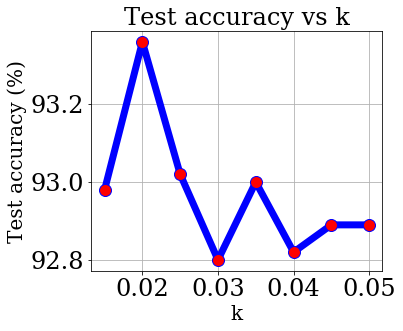

In [6]:
from matplotlib import rcParams


plt.tight_layout()

plt.rc('font', family='serif')
plt.rc('xtick', labelsize='large')
plt.rc('ytick', labelsize='large')
plt.rcParams.update({'font.size': 20})
rcParams.update({'figure.autolayout': True})


timing = [metrics[k]['time'] for k in metrics.keys()]
best_acc = [metrics[k]['best_val_acc'] for k in metrics.keys()]
k = list(metrics.keys())

plt.figure(figsize=(6,5))
plt.plot(k[2:],best_acc[2:],marker='o',color='blue',linewidth=7.0, markersize=12,mfc='red')
plt.title('Test accuracy vs k')
plt.xlabel('k')
plt.ylabel('Test accuracy (%)')
plt.grid(True)
# plt.show()
plt.savefig('figures/K_ablation/Resnet56_cifar10_accuracy_VS_K.png')